In [1]:
import pandas as pd


from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb

import scikitplot as skplt
import matplotlib.pyplot as plt

import cleaner as dc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df_train = pd.read_csv("./data/authority_train_dataset.csv")
df_test = pd.read_csv("./data/authority_test_dataset.csv")

print(df_train.shape)
print(df_test.shape)

(4071, 2)
(570, 2)


In [3]:
# Cleaning and lemmatizing the traning and testing datasets

# Lower case
df_train['ad']= df_train['ad'].apply(lambda x: x.lower())
df_test['ad']= df_test['ad'].apply(lambda x: x.lower())

# Removing punctuations
df_train['ad']= df_train['ad'].str.replace('[^\w\s]','', regex=True)
df_test['ad']= df_test['ad'].str.replace('[^\w\s]','', regex=True)

# Removing numbers
df_train['ad']= df_train['ad'].str.replace('\d+','',regex=True)
df_test['ad']= df_test['ad'].str.replace('\d+','',regex=True)

# Removing extra space 
df_train['ad']= df_train['ad'].str.replace('\s+', ' ',  regex=True)
df_test['ad']= df_test['ad'].str.replace('\s+', ' ',  regex=True)

#Apply denoise function
df_train['ad']= df_train['ad'].apply(dc.denoise_text)
df_test['ad']= df_test['ad'].apply(dc.denoise_text)

#Apply function on review column
df_train['ad']= df_train['ad'].apply(dc.remove_stopwords)
df_test['ad']= df_test['ad'].apply(dc.remove_stopwords)

#Apply function on review column
df_train['ad']= df_train['ad'].apply(dc.remove_special_characters)
df_test['ad']= df_test['ad'].apply(dc.remove_special_characters)

#Apply function on review column
df_train['ad']= df_train['ad'].apply(dc.simple_lemmatizer)
df_test['ad']= df_test['ad'].apply(dc.simple_lemmatizer)


In [4]:
X_train, X_test, y_train, y_test = df_train['ad'], df_test['ad'], df_train['authority'], df_test['authority']

In [5]:
# Use term frequency to represent documents
tf_vectorizer = CountVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [6]:
# Creatiing and testing the model
xgb_clf = xgb.XGBClassifier(
              learning_rate=0.3,
              max_depth=6, 
              n_estimators=300,
              subsample=0.6
             )
xgb_clf.fit(X_train_tf, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

accuracy:   0.895
              precision    recall  f1-score   support

no-authority       0.96      0.88      0.92       389
   authority       0.79      0.92      0.85       181

    accuracy                           0.89       570
   macro avg       0.87      0.90      0.88       570
weighted avg       0.90      0.89      0.90       570

confusion matrix:
[[344  45]
 [ 15 166]]



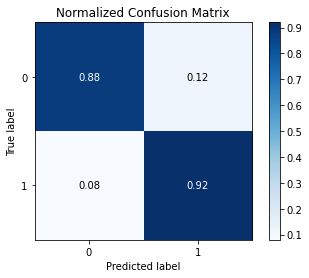

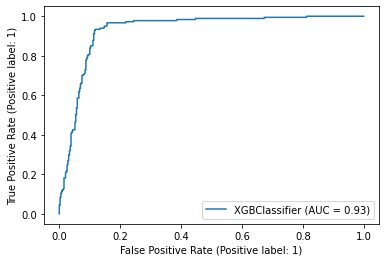

In [7]:
# predict the labels on validation dataset
predictions = xgb_clf.predict(X_test_tf)

# compute the performance measures
score1 = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_test, predictions, target_names=['no-authority', 'authority']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
svc_disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_test_tf, y_test)

In [8]:
df_val = pd.read_csv('data/sample.csv')

# Lower case
df_val['ad']= df_val['ad'].apply(lambda x: x.lower())

# Removing punctuations
df_val['ad']= df_val['ad'].str.replace('[^\w\s]','', regex=True)

# Removing numbers
df_val['ad']= df_val['ad'].str.replace('\d+','', regex=True)

# Removing extra space 
df_val['ad']= df_val['ad'].str.replace('\s+', ' ', regex=True)

#Apply function on review column
df_val['ad']= df_val['ad'].apply(dc.remove_stopwords)

#Apply function on review column
df_val['ad']= df_val['ad'].apply(dc.denoise_text)

#Apply function on review column
df_val['ad']= df_val['ad'].apply(dc.remove_special_characters)

#Apply function on review column
df_val['ad']= df_val['ad'].apply(dc.simple_lemmatizer)

accuracy:   0.829
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       113
           1       0.72      0.81      0.76        57

    accuracy                           0.83       170
   macro avg       0.81      0.82      0.81       170
weighted avg       0.84      0.83      0.83       170

confusion matrix:
[[95 18]
 [11 46]]



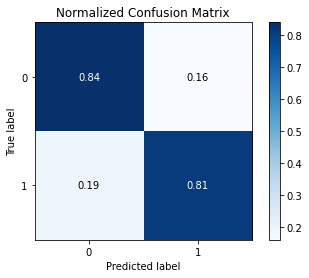

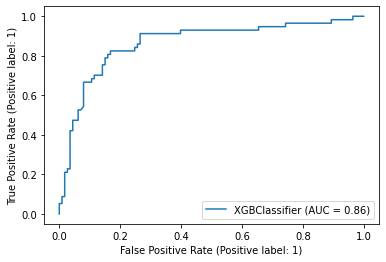

In [9]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['authority']

y_pred = xgb_clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ '0', '1']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(xgb_clf, X_val, y_val)